<pre><font size=6>Spoken Digit Recognition</font></pre>

<pre>
In this notebook, You will do Spoken Digit Recognition.

Input - speech signal, output - digit number



It contains  

1. Reading the dataset. and Preprocess the data set. Detailed instrctions are given below. You have to write the code in the same cell which contains the instrction.
2. Training the LSTM with RAW data
3. Converting to spectrogram and Training the LSTM network
4. Creating the augmented data and doing step 2 and 3 again.  

<font size=5>instructions:</font>

    1. Don't change any Grader Functions. Don't manipulate any Grader functions. If you manipulate any, it will be considered as plagiarised.
    
    2. Please read the instructions on the code cells and markdown cells. We will explain what to write.
    
    3. please return outputs in the same format what we asked. Eg. Don't return List of we are asking for a numpy array.
    
    4. Please read the external links that we are given so that you will learn the concept behind the code that you are writing.
    
    5. We are giving instructions at each section if necessary, please follow them.

<font size=5>Every Grader function has to return True. </font>

</pre>

In [ ]:
import numpy as np
import pandas as pd
import librosa
import os
import time
import zipfile
import glob
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
import datetime
##if you need any imports you can do that here.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

filepath = '/content/drive/MyDrive/Assignments/As30_Spoken digit recognition/'

Mounted at /content/drive


We shared recordings.zip, please unzip those.

In [ ]:
#read the all file names in the recordings folder given by us
#(if you get entire path, it is very useful in future)
#save those files names as list in "all_files"
%%time
if not os.path.isdir('recordings'):
    with zipfile.ZipFile(filepath+'recordings.zip', 'r') as zip_ref:
        zip_ref.extractall('./')

CPU times: user 294 ms, sys: 102 ms, total: 395 ms
Wall time: 2.16 s
Parser   : 140 ms


In [ ]:
# Capturing file paths using glob
all_files = glob.glob('recordings/*.wav')
print('sample filepaths     :', all_files[:2])
print('Number of audio files: ', len(all_files))

sample filepaths     : ['recordings/4_jackson_2.wav', 'recordings/4_jackson_13.wav']
Number of audio files:  2000


<font size=4>Grader function 1 </font>

In [ ]:
def grader_files():
    temp = len(all_files)==2000
    temp1 = all([x[-3:]=="wav" for x in all_files])
    temp = temp and temp1
    return temp
grader_files()

True

Create a dataframe(name=df_audio) with two columns(path, label).   
You can get the label from the first letter of name.  
Eg: 0_jackson_0 --> 0  
0_jackson_43 --> 0

In [ ]:
#Create a dataframe(name=df_audio) with two columns(path, label).
#You can get the label from the first letter of name.
#Eg: 0_jackson_0 --> 0
#0_jackson_43 --> 0
labels = []
for file in all_files:
    labels.append(int(file.split('/')[-1][0]))

df_audio = pd.DataFrame({'path': all_files, 'label': labels})

In [ ]:
#info
df_audio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    2000 non-null   object
 1   label   2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


<font size=4>Grader function 2 </font>

In [ ]:
def grader_df():
    flag_shape = df_audio.shape==(2000,2)
    flag_columns = all(df_audio.columns==['path', 'label'])
    list_values = list(df_audio.label.value_counts())
    flag_label = len(list_values)==10
    flag_label2 = all([i==200 for i in list_values])
    final_flag = flag_shape and flag_columns and flag_label and flag_label2
    return final_flag
grader_df()

True

In [ ]:
# Shuffle the data
from sklearn.utils import shuffle
df_audio = shuffle(df_audio, random_state=33)#don't change the random state

<pre><font size=4>Train and Validation split</font></pre>

In [ ]:
#split the data into train and validation and save in X_train, X_test, y_train, y_test
#use stratify sampling
#use random state of 45
#use test size of 30%
X_train, X_test, y_train, y_test = train_test_split(df_audio['path'], df_audio['label'], test_size=0.3, random_state=45, stratify= df_audio['label'])
print('Number of train data points:', len(X_train))
print('Number of test data points:', len(X_test))

Number of train data points: 1400
Number of test data points: 600


<font size=4>Grader function 3 </font>

In [ ]:
def grader_split():
    flag_len = (len(X_train)==1400) and (len(X_test)==600) and (len(y_train)==1400) and (len(y_test)==600)
    values_ytrain = list(y_train.value_counts())
    flag_ytrain = (len(values_ytrain)==10) and (all([i==140 for i in values_ytrain]))
    values_ytest = list(y_test.value_counts())
    flag_ytest = (len(values_ytest)==10) and (all([i==60 for i in values_ytest]))
    final_flag = flag_len and flag_ytrain and flag_ytest
    return final_flag
grader_split()

True

<pre><font size=4>Preprocessing</font>

All files are in the "WAV" format. We will read those raw data files using the librosa</pre>

In [ ]:
sample_rate = 22050
def load_wav(x, get_duration=True):
    '''This return the array values of audio with sampling rate of 22050 and Duration'''
    #loading the wav file with sampling rate of 22050
    samples, sample_rate = librosa.load(x, sr=22050)
    if get_duration:
        duration = librosa.get_duration(samples, sample_rate)
        return pd.Series([samples, duration])
    else:
        return samples

In [ ]:
%%time
#use load_wav function that was written above to get every wave.
#save it in X_train_processed and X_test_processed
# X_train_processed/X_test_processed should be dataframes with two columns(raw_data, duration) with same index of X_train/y_train
X_train_processed = X_train.apply(load_wav)
X_test_processed = X_test.apply(load_wav)
X_train_processed.columns = ['raw_data', 'duration']
X_test_processed.columns = ['raw_data', 'duration']

CPU times: user 21.2 s, sys: 385 ms, total: 21.6 s
Wall time: 21.5 s


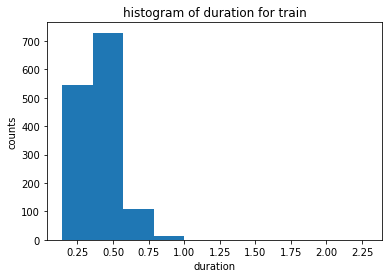

In [ ]:
#plot the histogram of the duration for train

plt.hist(X_train_processed.duration)
plt.xticks([0.25, 0.5, 0.75,1, 1.25,1.5,1.75,2,2.25])
plt.xlabel('duration')
plt.ylabel('counts')
plt.title('histogram of duration for train')
plt.show()

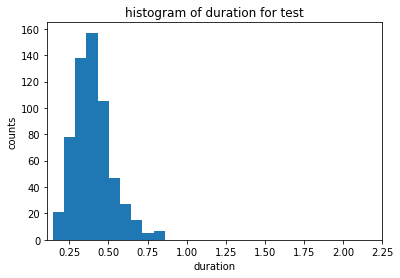

In [ ]:
#plot the histogram of the duration for test

plt.hist(X_test_processed.duration)
plt.xticks([0.25, 0.5, 0.75,1, 1.25,1.5,1.75,2,2.25])
plt.xlabel('duration')
plt.ylabel('counts')
plt.title('histogram of duration for test')
plt.show()

In [ ]:
#print 0 to 100 percentile values with step size of 10 for train data duration.
for i in range(0,101, 10):
    print(str(i),'th percentile is', np.percentile(X_train_processed.duration, i))

0 th percentile is 0.1435374149659864
10 th percentile is 0.26082993197278914
20 th percentile is 0.29872108843537415
30 th percentile is 0.33207256235827665
40 th percentile is 0.35835827664399095
50 th percentile is 0.38945578231292516
60 th percentile is 0.4174784580498867
70 th percentile is 0.44769160997732427
80 th percentile is 0.48297505668934243
90 th percentile is 0.5538775510204081
100 th percentile is 2.282766439909297


In [ ]:
##print 90 to 100 percentile values with step size of 1.
for i in range(90,101):
    print(str(i),'th percentile is', np.percentile(X_train_processed.duration, i))

90 th percentile is 0.5538775510204081
91 th percentile is 0.569807709750567
92 th percentile is 0.5811664399092972
93 th percentile is 0.5978285714285716
94 th percentile is 0.6120943310657596
95 th percentile is 0.6230884353741496
96 th percentile is 0.6385142857142857
97 th percentile is 0.6549514739229023
98 th percentile is 0.6834086167800454
99 th percentile is 0.7930485260770974
100 th percentile is 2.282766439909297


<font size=4>Grader function 4 </font>

In [ ]:
def grader_processed():
    flag_columns = (all(X_train_processed.columns==['raw_data', 'duration'])) and (all(X_test_processed.columns==['raw_data', 'duration']))
    flag_shape = (X_train_processed.shape ==(1400, 2)) and (X_test_processed.shape==(600,2))
    return flag_columns and flag_shape
grader_processed()

True

<pre>Based on our analysis 99 percentile values are less than 0.8sec so we will limit maximum length of X_train_processed and X_test_processed to 0.8 sec. It is similar to pad_sequence for a text dataset.

While loading the audio files, we are using sampling rate of 22050 so one sec will give array of length 22050. so, our maximum length is 0.8*22050 = 17640

Pad with Zero if length of sequence is less than 17640 else Truncate the number.

Also create a masking vector for train and test.

masking vector value = 1 if it is real value, 0 if it is pad value. Masking vector data type must be bool.
</pre>

In [ ]:
# max_length = sampling rate * duration selected i.e, 22050 * 0.8
max_length  = 17640

In [ ]:
def mask(sequence):
    if len(sequence) < max_length:
        return np.array([1]*len(sequence) + [0]*(max_length-len(sequence)), dtype=np.bool_)
    else:
        return np.array([1]*max_length, dtype=np.bool_)

In [ ]:
## as discussed above, Pad with Zero if length of sequence is less than 17640 else Truncate the number.
## save in the X_train_pad_seq, X_test_pad_seq
## also Create masking vector X_train_mask, X_test_mask
## all the X_train_pad_seq, X_test_pad_seq, X_train_mask, X_test_mask will be numpy arrays mask vector dtype must be bool.

X_train_pad_seq = pad_sequences(X_train_processed['raw_data'], maxlen=max_length, padding='post', dtype=np.float32)
X_test_pad_seq = pad_sequences(X_test_processed['raw_data'], maxlen=max_length, padding='post', dtype=np.float32)

X_train_mask = np.vstack(X_train_processed['raw_data'].apply(mask).values)
X_test_mask = np.vstack(X_test_processed['raw_data'].apply(mask).values)

<font size=4>Grader function 5 </font>

In [ ]:
def grader_padoutput():
    flag_padshape = (X_train_pad_seq.shape==(1400, 17640)) and (X_test_pad_seq.shape==(600, 17640)) and (y_train.shape==(1400,))
    flag_maskshape = (X_train_mask.shape==(1400, 17640)) and (X_test_mask.shape==(600, 17640)) and (y_test.shape==(600,))
    flag_dtype = (X_train_mask.dtype==bool) and (X_test_mask.dtype==bool)
    return flag_padshape and flag_maskshape and flag_dtype
grader_padoutput()

True

### Misc. Functions

In [ ]:
from sklearn.metrics import f1_score
import tensorflow as tf

class Metrics(tf.keras.callbacks.Callback):

    def __init__(self, train_data, validation_data):
        self.train_data = train_data
        self.validation_data = validation_data

    def on_train_begin(self, logs={}):
        # Initiating history log
        self.history = {'micro_F1s': [], 'val_micro_F1s': []}

    def on_epoch_end(self, epoch, logs={}):
        X_train, y_train = self.train_data[0], self.train_data[1]
        X_val, y_val = self.validation_data[0], self.validation_data[1]

        train_pred = np.argmax(np.asarray(self.model.predict(X_train)), axis=1)          # model prediction on train data
        val_pred = np.argmax(np.asarray(self.model.predict(X_val)), axis=1)               # model prediction on test data

        train_f1 = f1_score(y_train, train_pred.round(), average = 'micro')   # Micro_f1 score on train data
        val_f1 = f1_score(y_test, val_pred.round(), average='micro')           # Micro_f1 score on cv data

        # Appending log
        self.history['micro_F1s'].append(train_f1)
        self.history['val_micro_F1s'].append(val_f1)

        print("                                       - micro_f1: {} - val_micro_f1: {}".format(np.round(train_f1,4), np.round(val_f1,4)))

In [ ]:
import matplotlib.image as mpimg
# To display tensorboard images

def display_image(file):
    plt.figure(figsize=(15,20))
    img = mpimg.imread(file)
    imgplot = plt.imshow(img)
    plt.show()

<pre>
Now we have

Train data: X_train_pad_seq, X_train_mask and y_train  
Test data: X_test_pad_seq, X_test_mask and y_test   

We will create a LSTM model which takes this input.

Task:

1. Create an LSTM network which takes "X_train_pad_seq" as input, "X_train_mask" as mask input. You can use any number of LSTM cells. Please read LSTM documentation(https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) in tensorflow to know more about mask and also https://www.tensorflow.org/guide/keras/masking_and_padding
2. Get the final output of the LSTM and give it to Dense layer of any size and then give it to Dense layer of size 10(because we have 10 outputs) and then compile with the sparse categorical cross entropy( because we are not converting it to one hot vectors).
3. Use tensorboard to plot the graphs of loss and metric(use micro F1 score as metric) and histograms of gradients.
4. make sure that it won't overfit.
5. You are free to include any regularization
</pre>

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed, Reshape, GlobalAveragePooling1D
from tensorflow.keras.models import Model, load_model
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, Nadam

In [ ]:
## as discussed above, please write the LSTM
def Model_1():

    inp_1 = Input(shape=(17640,1))
    mask_input = Input(shape=(17640), dtype=np.bool_)

    X = LSTM(25)(inp_1, mask=mask_input)
    X = Dense(100)(X)
    output = Dense(10, activation='softmax')(X)

    model = Model([inp_1, mask_input], output)

    return model

tf.keras.backend.clear_session()
model_1 = Model_1()
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 17640, 1)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 17640)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 25)           2700        input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 100)          2600        lstm[0][0]                   

In [ ]:
# Callbacks
metrics = Metrics([[X_train_pad_seq, X_train_mask], y_train], [[X_test_pad_seq, X_test_mask], y_test])

early_stopping = EarlyStopping(monitor='accuracy', min_delta=0, mode='max', patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('./best_model_1.h5',monitor='accuracy', mode='max', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='accuracy', min_lr=0.000001,patience=2)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callback_list = [metrics, early_stopping, model_checkpoint, reduce_lr, tensorboard_callback]

In [ ]:
#train your model
tf.keras.backend.clear_session()
model_1.compile(optimizer=Nadam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_1.fit(x=[X_train_pad_seq, X_train_mask], y=y_train, batch_size=128, epochs=20,
          validation_data=([X_test_pad_seq, X_test_mask], y_test), callbacks=callback_list)

Epoch 1/20
11/11 [==============================] - 16s 1s/step - loss: 2.3032 - accuracy: 0.0893 - val_loss: 2.3026 - val_accuracy: 0.1000
                                       - micro_f1: 0.1014 - val_micro_f1: 0.1
Epoch 2/20
11/11 [==============================] - 6s 599ms/step - loss: 2.3031 - accuracy: 0.1007 - val_loss: 2.3026 - val_accuracy: 0.1000
                                       - micro_f1: 0.1014 - val_micro_f1: 0.1
Epoch 3/20
11/11 [==============================] - 6s 577ms/step - loss: 2.3031 - accuracy: 0.0850 - val_loss: 2.3026 - val_accuracy: 0.1000
                                       - micro_f1: 0.1007 - val_micro_f1: 0.1
Epoch 4/20
11/11 [==============================] - 6s 589ms/step - loss: 2.3033 - accuracy: 0.0936 - val_loss: 2.3026 - val_accuracy: 0.1000
                                       - micro_f1: 0.1014 - val_micro_f1: 0.1
Epoch 5/20
11/11 [==============================] - 7s 609ms/step - loss: 2.3025 - accuracy: 0.1014 - val_loss: 2.3026 - v

In [ ]:
# Evaluating the model 1
best_model_1 = load_model(filepath+'best_model_1.h5')

_, train_accuracy = best_model_1.evaluate([X_train_pad_seq, X_train_mask], y_train)
_, test_accuracy = best_model_1.evaluate([X_test_pad_seq, X_test_mask], y_test)
print('\nAccuracy on training data:', round(train_accuracy*100,2),'%')
print('Accuracy on test data:', round(test_accuracy*100,2),'%')

# F1-Score
y_train_pred = np.argmax(best_model_1.predict([X_train_pad_seq, X_train_mask]), axis=1)
y_test_pred = np.argmax(best_model_1.predict([X_test_pad_seq, X_test_mask]), axis=1)
print('\nf1_score on training data : %.2f' % (f1_score(y_train, y_train_pred, average='micro')*100), '%')
print('f1_score on test data : %.2f' % (f1_score(y_test, y_test_pred, average='micro')*100), '%')

print('\noverfitting Percentage     :', round((train_accuracy-test_accuracy)*100,2),'%')
print('Good fit model')

19/19 [==============================] - 4s 199ms/step - loss: 2.3025 - accuracy: 0.1033

Accuracy on training data: 10.07 %
Accuracy on test data: 10.33 %

f1_score on training data : 10.07 %
f1_score on test data : 10.33 %

overfitting Percentage     : -0.26 %
Good fit model


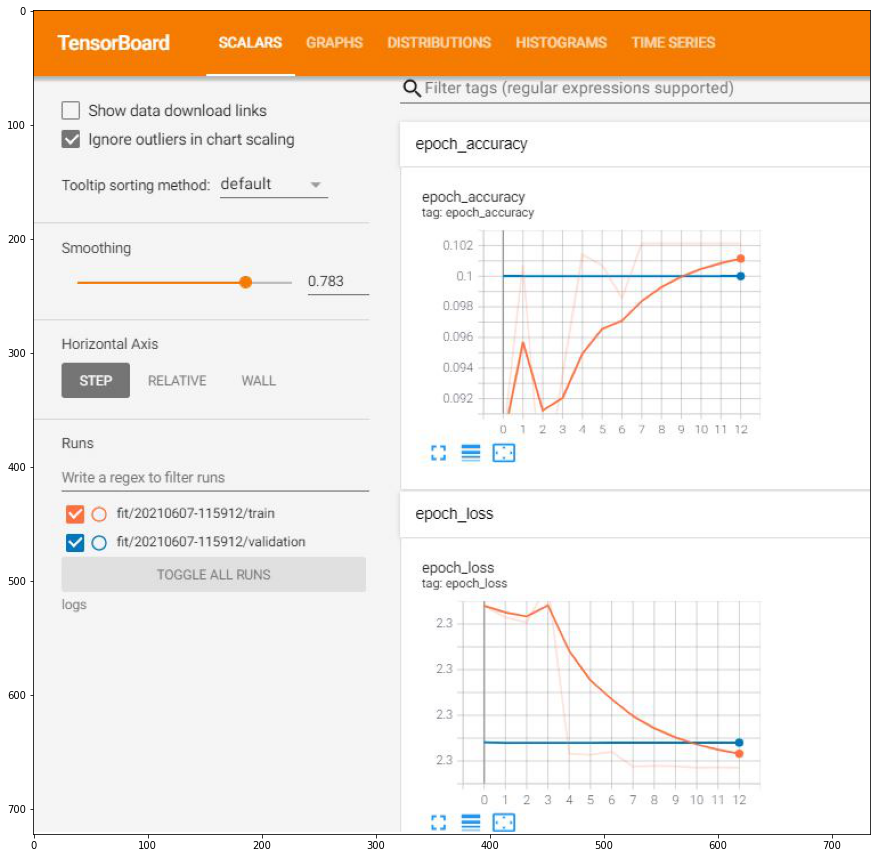

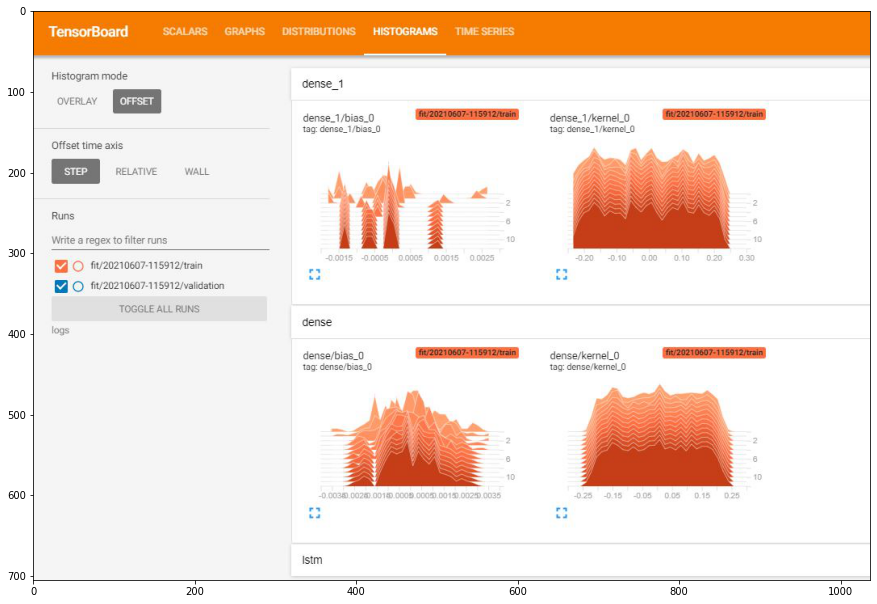

In [ ]:
# tensorboard images for model 1
display_image(filepath+'tensorboard_model_1.JPG')
display_image(filepath+'histograms_model_1.JPG')

### 2. Converting into spectrogram and giving spectrogram data as input  
<pre>
We can use librosa to convert raw data into spectrogram. A spectrogram shows the features in a two-dimensional representation with the
intensity of a frequency at a point in time i.e we are converting Time domain to frequency domain. you can read more about this in https://pnsn.org/spectrograms/what-is-a-spectrogram
</pre>

In [ ]:
def convert_to_spectrogram(raw_data):
    '''converting to spectrogram'''
    spectrum = librosa.feature.melspectrogram(y=raw_data, sr=sample_rate, n_mels=64)
    logmel_spectrum = librosa.power_to_db(S=spectrum, ref=np.max)
    return logmel_spectrum

In [ ]:
##use convert_to_spectrogram and convert every raw sequence in X_train_pad_seq and X_test_pad-seq.
## save those all in the X_train_spectrogram and X_test_spectrogram ( These two arrays must be numpy arrays)
X_train_spectrogram = []
X_test_spectrogram =  []

for seq in tqdm(X_train_pad_seq):
    X_train_spectrogram.append(convert_to_spectrogram(seq))

for seq in tqdm(X_test_pad_seq):
    X_test_spectrogram.append(convert_to_spectrogram(seq))

X_train_spectrogram = np.array(X_train_spectrogram)
X_test_spectrogram = np.array(X_test_spectrogram)

100%|██████████| 600/600 [00:02<00:00, 218.45it/s]


<font size=4>Grader function 6 </font>

In [ ]:
def grader_spectrogram():
    flag_shape = (X_train_spectrogram.shape==(1400,64,35)) and (X_test_spectrogram.shape == (600, 64, 35))
    return flag_shape
grader_spectrogram()

True

<pre>
Now we have

Train data: X_train_spectrogram and y_train  
Test data: X_test_spectrogram and y_test   

We will create a LSTM model which takes this input.

Task:

1. Create an LSTM network which takes "X_train_spectrogram" as input and has to return output at every time step.
2. Average the output of every time step and give this to the Dense layer of any size.
(ex: Output from LSTM will be  (#., time_steps, features) average the output of every time step i.e, you should get (#.,time_steps)
and then pass to dense layer )
3. give the above output to Dense layer of size 10( output layer) and train the network with sparse categorical cross entropy.  
4. Use tensorboard to plot the graphs of loss and metric(use micro F1 score as metric) and histograms of gradients.
5. make sure that it won't overfit.
6. You are free to include any regularization
</pre>

In [ ]:
# https://stackoverflow.com/questions/65185733/how-to-apply-average-pooling-at-each-time-step-of-lstm-output

def Model_2():

    inp = Input(shape=(64,35))
    X = LSTM(128, return_sequences=True, kernel_regularizer='l2')(inp)
    # Average the output of every time step
    X = Reshape(target_shape=(64,128,1))(X)
    X = tf.keras.layers.TimeDistributed(GlobalAveragePooling1D())(X)
    X = Reshape(target_shape=(64,))(X)

    X = Dense(100)(X)
    output = Dense(10, activation='softmax')(X)

    model = Model([inp], output)

    return model

tf.keras.backend.clear_session()
model_2 = Model_2()
model_2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 35)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64, 128)           83968     
_________________________________________________________________
reshape (Reshape)            (None, 64, 128, 1)        0         
_________________________________________________________________
time_distributed (TimeDistri (None, 64, 1)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 100)               6500      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010  

In [ ]:
# Callbacks

metrics = Metrics([X_train_spectrogram, y_train], [X_test_spectrogram, y_test])

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, mode='max', patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('./best_model_2.h5', monitor='val_accuracy', mode='max', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', min_lr=0.000001,patience=2)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callback_list = [metrics, early_stopping, reduce_lr, model_checkpoint,tensorboard_callback]

In [ ]:
#train your model
tf.keras.backend.clear_session()
model_2.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_2.fit(x=X_train_spectrogram, y=y_train, batch_size=128, epochs=200,
          validation_data=(X_test_spectrogram, y_test), callbacks=callback_list)

Epoch 1/200
11/11 [==============================] - 5s 327ms/step - loss: 2.8344 - accuracy: 0.1586 - val_loss: 2.6962 - val_accuracy: 0.2100
                                       - micro_f1: 0.215 - val_micro_f1: 0.21
Epoch 2/200
11/11 [==============================] - 0s 15ms/step - loss: 2.5929 - accuracy: 0.2457 - val_loss: 2.4748 - val_accuracy: 0.2950
                                       - micro_f1: 0.2807 - val_micro_f1: 0.295
Epoch 3/200
11/11 [==============================] - 0s 13ms/step - loss: 2.3786 - accuracy: 0.3086 - val_loss: 2.2648 - val_accuracy: 0.3350
                                       - micro_f1: 0.35 - val_micro_f1: 0.335
Epoch 4/200
11/11 [==============================] - 0s 12ms/step - loss: 2.1544 - accuracy: 0.4214 - val_loss: 2.0318 - val_accuracy: 0.4600
                                       - micro_f1: 0.4586 - val_micro_f1: 0.46
Epoch 5/200
11/11 [==============================] - 0s 11ms/step - loss: 1.9323 - accuracy: 0.4686 - val_loss: 1.81

In [ ]:
# Evaluating model_2

best_model_2 = load_model(filepath+'best_model_2.h5')

_, train_accuracy = best_model_2.evaluate(X_train_spectrogram, y_train)
_, test_accuracy = best_model_2.evaluate(X_test_spectrogram, y_test)

print('\nAccuracy on training data:', round(train_accuracy*100,2),'%')
print('Accuracy on test data      :', round(test_accuracy*100,2),'%')

# F1-Score
y_train_pred = np.argmax(best_model_2.predict(X_train_spectrogram), axis=1)
y_test_pred = np.argmax(best_model_2.predict(X_test_spectrogram), axis=1)
print('\nf1_score on training data : %.2f' % (f1_score(y_train, y_train_pred, average='micro')*100), '%')
print('f1_score on test data : %.2f' % (f1_score(y_test, y_test_pred, average='micro')*100), '%')

print('\noverfitting Percentage     :', round((train_accuracy-test_accuracy)*100,2),'%')
print('Good fit model')

19/19 [==============================] - 0s 4ms/step - loss: 0.6923 - accuracy: 0.8200

Accuracy on training data: 83.64 %
Accuracy on test data      : 82.0 %

f1_score on training data : 83.64 %
f1_score on test data : 82.00 %

overfitting Percentage     : 1.64 %
Good fit model


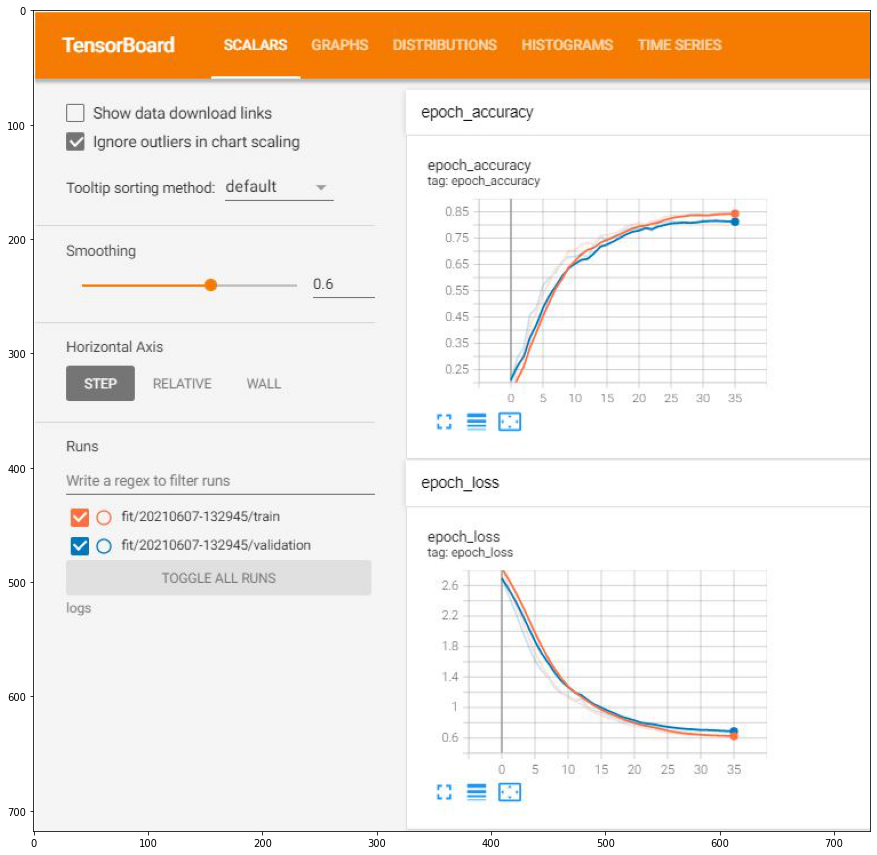

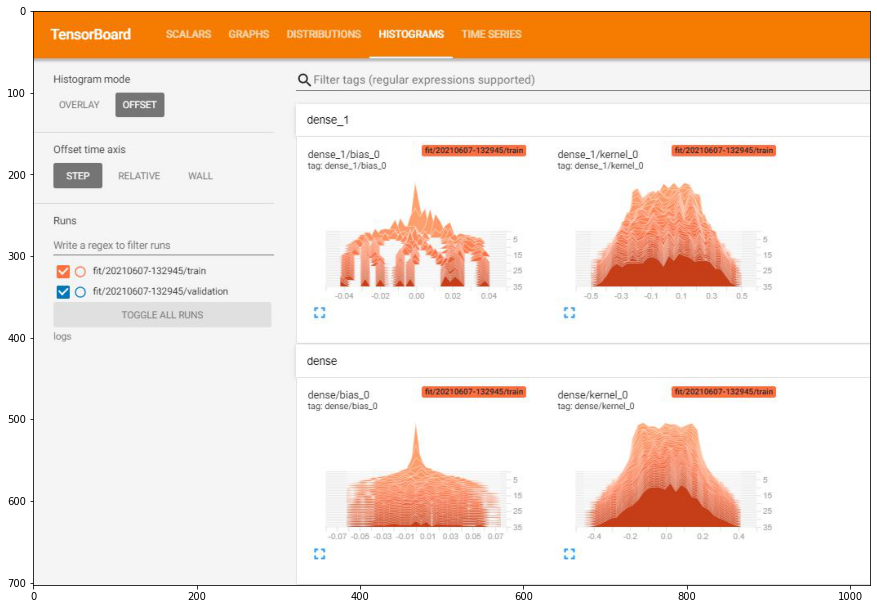

In [ ]:
# Tensorboard images for model 2
display_image(filepath+'tensorboard_model_2.JPG')
display_image(filepath+'histograms_model_2.JPG')

### 3. data augmentation  
<pre>
Till now we have done with 2000 samples only. It is very less data. We are giving the process of generating augmented data below.

There are two types of augmentation:
1. time stretching - Time stretching either increases or decreases the length of the file. For time stretching we move the file 30% faster or slower
2. pitch shifting - pitch shifting moves the frequencies higher or lower. For pitch shifting we shift up or down one half-step.
</pre>

As discussed above, for one data point, we will get 9 augmented data points.  

Split data into train and test (80-20 split)

We have 2000 data points(1600 train points, 400 test points)

Do augmentation only on train data, after augmentation we will get 14400 train points.

do the above steps i.e training with raw data and spectrogram data with augmentation.

In [ ]:
## generating augmented data.
def generate_augmented_data(file_path):
    augmented_data = []
    samples = load_wav(file_path,get_duration=False)
    for time_value in [0.7, 1, 1.3]:
        for pitch_value in [-1, 0, 1]:
            time_stretch_data = librosa.effects.time_stretch(samples, rate=time_value)
            final_data = librosa.effects.pitch_shift(time_stretch_data, sr=sample_rate, n_steps=pitch_value)
            augmented_data.append(final_data)
    return augmented_data

In [ ]:
# Split the data in 80-20 ratio
X_train, X_test, y_train, y_test = train_test_split(df_audio['path'], df_audio['label'], test_size=0.2, random_state=45, stratify= df_audio['label'])
print('Number of train data points:', len(X_train))
print('Number of test data points:', len(X_test))

Number of train data points: 1600
Number of test data points: 400


In [ ]:
# Augment train data
X_train_aug = []
for file in tqdm(X_train):
    X_train_aug.append(generate_augmented_data(file))

X_train_aug = np.array(X_train_aug, dtype='object').ravel()
print('Shape of train data after augmentation:', X_train_aug.shape)

100%|██████████| 1600/1600 [05:18<00:00,  5.02it/s]

Shape of train data after augmentation: (14400,)


In [ ]:
# prepare train targets to match augmented data
y_train_aug = []
for label in y_train:
    for _ in range(9):
        y_train_aug.append(label)

y_train_aug = np.array(y_train_aug)  # Converting to numpy array

print('Number of target labels:', len(y_train_aug))
pd.Series(y_train_aug).value_counts()

Number of target labels: 14400


7    1440
6    1440
5    1440
4    1440
3    1440
2    1440
9    1440
1    1440
8    1440
0    1440
dtype: int64

### Model_3

In [ ]:
## as discussed above, Pad with Zero if length of sequence is less than 17640 else Truncate the number.
## save in the X_train_pad_seq, X_test_pad_seq
## also Create masking vector X_train_mask, X_test_mask
## all the X_train_pad_seq, X_test_pad_seq, X_train_mask, X_test_mask will be numpy arrays mask vector dtype must be bool.

X_train_pad_seq = pad_sequences(X_train_aug, maxlen=max_length, padding='post', dtype=np.float32)

X_train_mask = np.vstack(pd.Series(X_train_aug).apply(mask).values)

In [ ]:
# preparing test data
X_test_processed = X_test.apply(load_wav)
X_test_processed.columns = ['raw_data', 'duration']
X_test_pad_seq = pad_sequences(X_test_processed['raw_data'], maxlen=max_length, padding='post', dtype=np.float32)

X_test_mask = np.vstack(X_test_processed['raw_data'].apply(mask).values)

In [ ]:
# Callbacks
metrics = Metrics([[X_train_pad_seq, X_train_mask], y_train_aug], [[X_test_pad_seq, X_test_mask], y_test])
early_stopping = EarlyStopping(monitor='accuracy', min_delta=0, mode='max', patience=3, verbose=1)
model_checkpoint = ModelCheckpoint('./best_model_3.h5',monitor='accuracy', mode='max', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='accuracy', min_lr=0.000001, mode='max', patience=2)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callback_list = [metrics, early_stopping, reduce_lr, model_checkpoint, tensorboard_callback]

In [ ]:
#train your model
tf.keras.backend.clear_session()
model_3 = Model_1()
model_3.compile(optimizer=Nadam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_3.fit(x=[X_train_pad_seq, X_train_mask], y=y_train_aug, batch_size=128, epochs=20,
          validation_data=([X_test_pad_seq, X_test_mask], y_test), callbacks=callback_list)

Epoch 1/20
113/113 [==============================] - 69s 568ms/step - loss: 2.3032 - accuracy: 0.0972 - val_loss: 2.3027 - val_accuracy: 0.0975
                                       - micro_f1: 0.0999 - val_micro_f1: 0.0975
Epoch 2/20
113/113 [==============================] - 58s 513ms/step - loss: 2.3031 - accuracy: 0.0963 - val_loss: 2.3027 - val_accuracy: 0.0950
                                       - micro_f1: 0.0997 - val_micro_f1: 0.095
Epoch 3/20
113/113 [==============================] - 58s 515ms/step - loss: 2.3029 - accuracy: 0.0988 - val_loss: 2.3030 - val_accuracy: 0.0975
                                       - micro_f1: 0.1 - val_micro_f1: 0.0975
Epoch 4/20
113/113 [==============================] - 58s 510ms/step - loss: 2.3030 - accuracy: 0.0979 - val_loss: 2.3028 - val_accuracy: 0.1000
                                       - micro_f1: 0.1 - val_micro_f1: 0.1
Epoch 5/20
113/113 [==============================] - 58s 511ms/step - loss: 2.3031 - accuracy: 0.0988 - v

In [ ]:
# Evaluate model 3
best_model_3 = load_model('./best_model_3.h5')

# Accuracy
_, train_accuracy = best_model_3.evaluate([X_train_pad_seq, X_train_mask], y_train_aug)
_, test_accuracy = best_model_3.evaluate([X_test_pad_seq, X_test_mask], y_test)
print('\nAccuracy on training data:', round(train_accuracy*100,2),'%')
print('Accuracy on test data      :', round(test_accuracy*100,2),'%')

# F1-Score
y_train_pred = np.argmax(best_model_3.predict([X_train_pad_seq, X_train_mask]), axis=1)
y_test_pred = np.argmax(best_model_3.predict([X_test_pad_seq, X_test_mask]), axis=1)
print('\nf1_score on training data : %.2f' % (f1_score(y_train_aug, y_train_pred, average='micro')*100), '%')
print('f1_score on test data : %.2f' % (f1_score(y_test, y_test_pred, average='micro')*100), '%')

print('\noverfitting Percentage     :', round((train_accuracy-test_accuracy)*100,2),'%')
print('Good fit model')

13/13 [==============================] - 4s 183ms/step - loss: 2.3027 - accuracy: 0.1000

Accuracy on training data: 10.0 %
Accuracy on test data      : 10.0 %

f1_score on training data : 10.00 %
f1_score on test data : 10.00 %

overfitting Percentage     : 0.0 %
Good fit model


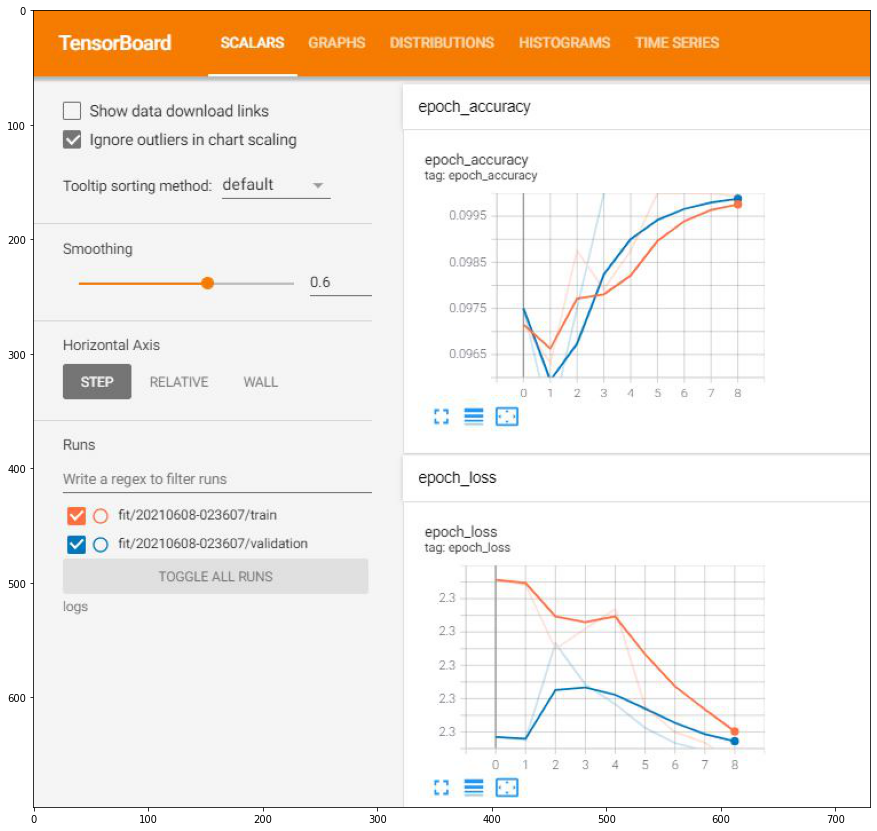

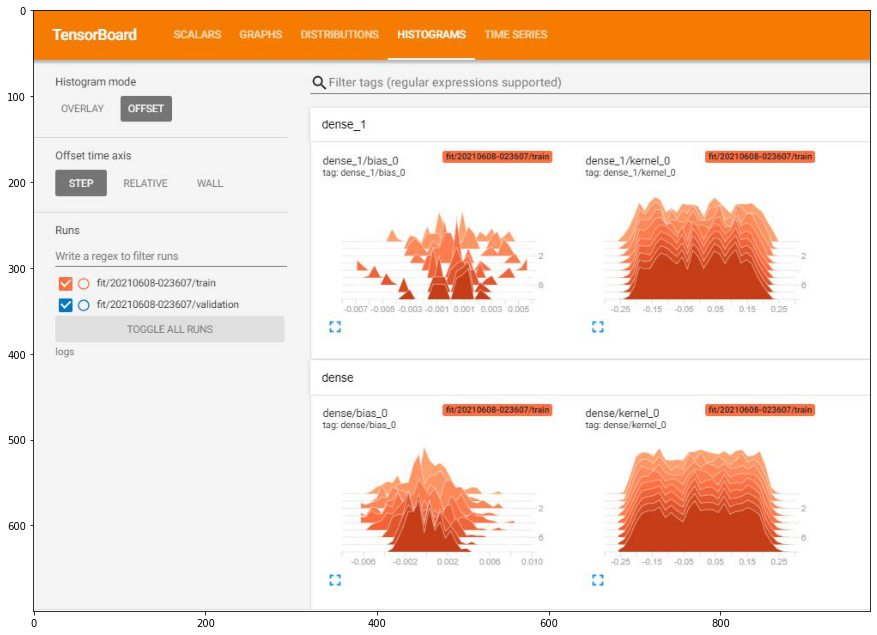

In [ ]:
# Tensorboard images
display_image(filepath+'tensorboard_model_3.JPG')
display_image(filepath+'histograms_model_3.JPG')

### Model_4

In [ ]:
##use convert_to_spectrogram and convert every raw sequence in X_train_pad_seq and X_test_pad-seq.
## save those all in the X_train_spectrogram and X_test_spectrogram ( These two arrays must be numpy arrays)
X_train_spectrogram = []

for seq in tqdm(X_train_pad_seq):
    X_train_spectrogram.append(convert_to_spectrogram(seq))

X_train_spectrogram = np.array(X_train_spectrogram)

100%|██████████| 14400/14400 [01:05<00:00, 219.95it/s]


In [ ]:
# Spectragrams for augmented data
X_test_spectrogram = []

for seq in tqdm(X_test_pad_seq):
    X_test_spectrogram.append(convert_to_spectrogram(seq))

X_test_spectrogram = np.array(X_test_spectrogram)

100%|██████████| 400/400 [00:01<00:00, 230.30it/s]


In [ ]:
# Callbacks
metrics = Metrics([X_train_spectrogram, y_train_aug], [X_test_spectrogram, y_test])
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, mode='max', patience=10, verbose=1)
model_checkpoint = ModelCheckpoint('./best_model_4.h5', monitor='val_accuracy', mode='max', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', min_lr=0.000001,patience=2)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callback_list = [metrics, early_stopping, reduce_lr, model_checkpoint,tensorboard_callback]

In [ ]:
#train your model
tf.keras.backend.clear_session()
model_4 = Model_2()
model_4.compile(optimizer=Nadam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_4.fit(x=X_train_spectrogram, y=y_train_aug, batch_size=128, epochs=200,
          validation_data=(X_test_spectrogram, y_test), callbacks=callback_list)

Epoch 1/200
113/113 [==============================] - 4s 20ms/step - loss: 2.2261 - accuracy: 0.3128 - val_loss: 1.5858 - val_accuracy: 0.5300
                                       - micro_f1: 0.4955 - val_micro_f1: 0.53
Epoch 2/200
113/113 [==============================] - 1s 10ms/step - loss: 1.3315 - accuracy: 0.5867 - val_loss: 1.0704 - val_accuracy: 0.6900
                                       - micro_f1: 0.6645 - val_micro_f1: 0.69
Epoch 3/200
113/113 [==============================] - 1s 10ms/step - loss: 0.9808 - accuracy: 0.6961 - val_loss: 0.7967 - val_accuracy: 0.7800
                                       - micro_f1: 0.7391 - val_micro_f1: 0.78
Epoch 4/200
113/113 [==============================] - 1s 10ms/step - loss: 0.8019 - accuracy: 0.7557 - val_loss: 0.6724 - val_accuracy: 0.8200
                                       - micro_f1: 0.7792 - val_micro_f1: 0.82
Epoch 5/200
113/113 [==============================] - 1s 10ms/step - loss: 0.7086 - accuracy: 0.7840 - val_

In [ ]:
from tensorflow.keras.models import save_model
# Saving the last model as the difference between train score and validation score is less compared to highest validation score
save_model(model_4, './best_model_4.h5')

In [ ]:
# Evaluate the model 4
best_model_4 = load_model('./best_model_4.h5')

_, train_accuracy = best_model_4.evaluate(X_train_spectrogram, y_train_aug)
_, test_accuracy = best_model_4.evaluate(X_test_spectrogram, y_test)

print('\nAccuracy on training data:', round(train_accuracy*100,2),'%')
print('Accuracy on test data      :', round(test_accuracy*100,2),'%')

# F1-Score
y_train_pred = np.argmax(best_model_4.predict(X_train_spectrogram), axis=1)
y_test_pred = np.argmax(best_model_4.predict(X_test_spectrogram), axis=1)
print('\nf1_score on training data : %.2f' % (f1_score(y_train_aug, y_train_pred, average='micro')*100), '%')
print('f1_score on test data : %.2f' % (f1_score(y_test, y_test_pred, average='micro')*100), '%')

print('\noverfitting Percentage     :', round((train_accuracy-test_accuracy)*100,2),'%')
print('Good fit model')

13/13 [==============================] - 0s 5ms/step - loss: 0.3138 - accuracy: 0.9225

Accuracy on training data: 91.19 %
Accuracy on test data      : 92.25 %

f1_score on training data : 91.19 %
f1_score on test data : 92.25 %

overfitting Percentage     : -1.06 %
Good fit model


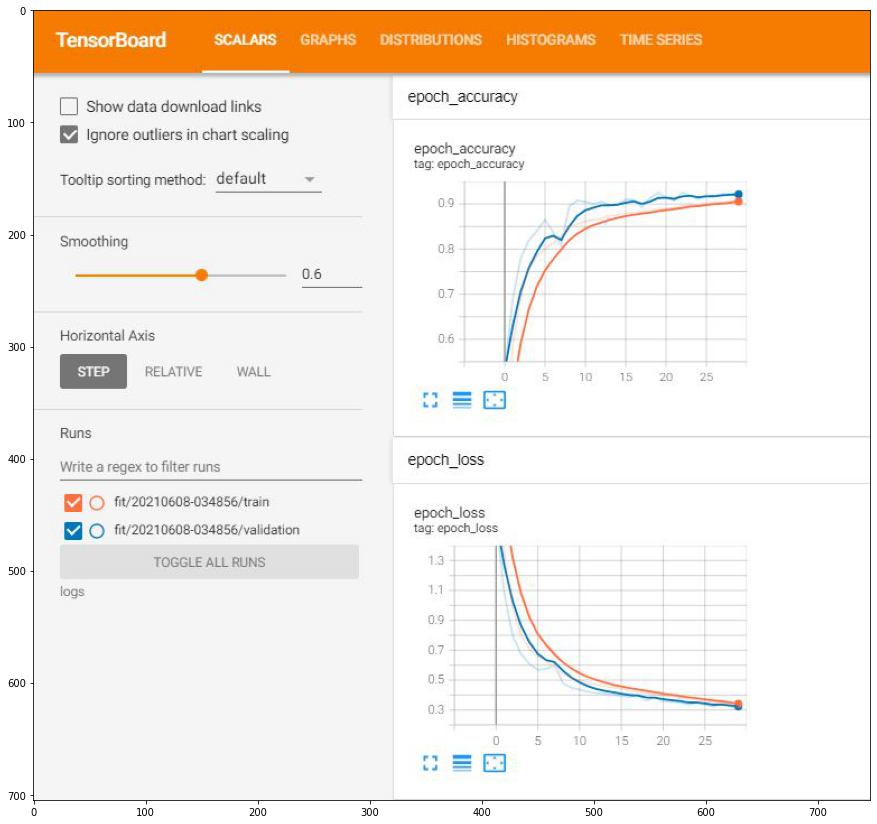

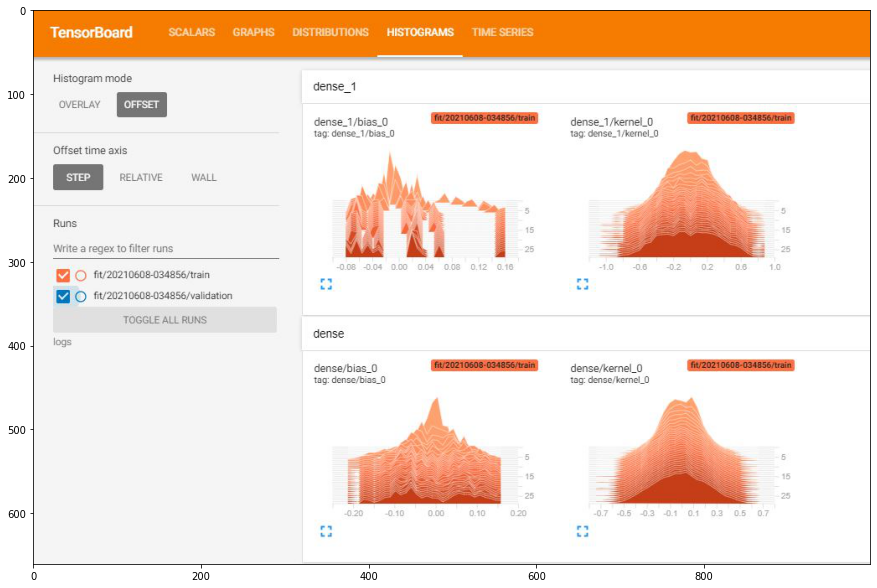

In [ ]:
# Tensorboard images for model 4
display_image(filepath+'tensorboard_model_4.JPG')
display_image(filepath+'histograms_model_4.JPG')

### Observation

1. Accuracy and micro f1 scores are same. Hence, monitored accuracy in callbacks
2. Model 1 and model 3 are predicting all data points to be one class. Hence, we are getting 10% score though we are using more data by augmenting for training the model 3
3. We can see from graph that validation loss and accuracy score are almost constant over all epochs for model 1 and 3
4. Model 2 is performing very well that is score about 82% with just 1600 data points after converting the audio signals to mel_spectrograms
5. Model 2 and graph of loss and accuracy looks smooth over the training epochs
6. Histograms of gradients for Models 2 and 4 is narrow like normal distribution compared to Models 1 and 3 which are spread
7. By augmenting the data and with mel_spectrograms, model 4 is able to achieve 10% higher accuracy compared to model 2 which just uses mel_spectrograms
8. So, model 4 is the best performing model with about 92% accuracy

### Tensorboard

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [ ]:
# %load_ext tensorboard
%tensorboard --logdir logs